In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # For making figures
%matplotlib inline

In [22]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [23]:
len(words)

32033

In [24]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [25]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one
X, Y = [],[]
for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [26]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [27]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one
    X, Y = [],[]
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [28]:
# C is a lookup table
C = torch.randn((27, 2)) # 27 row x 2 columns

In [29]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [30]:
W1 = torch.randn((6, 100)) # embedding has shape of 32 x 3 x 2 so 3 x 2 = 6 inputs
b1 = torch.randn(100)

In [31]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [32]:
h

tensor([[ 0.9958, -0.6150, -0.9910,  ...,  0.9978, -0.8980,  1.0000],
        [ 0.7719,  0.6826,  0.1596,  ...,  0.9941,  0.1951,  0.9973],
        [ 0.1235, -0.5364,  0.4879,  ...,  0.9646, -0.9997,  0.9988],
        ...,
        [ 0.9992,  0.9948, -1.0000,  ...,  0.1390,  0.1586,  0.9951],
        [-0.9503, -0.9194, -0.0966,  ...,  0.9975,  0.7422,  0.8989],
        [ 0.9995, -0.1377,  0.4895,  ...,  0.9638, -0.9996,  0.9904]])

In [33]:
h.shape

torch.Size([228146, 100])

In [34]:
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [35]:
logits = h @ w2 + b2

In [36]:
logits.shape

torch.Size([228146, 27])

In [37]:
counts = logits.exp()

In [38]:
prob = counts / counts.sum(1, keepdims=True)

In [39]:
prob.shape

torch.Size([228146, 27])

In [40]:
# -------------- now made respectable :) --------------

In [41]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [42]:
g = torch.Generator().manual_seed(2147483647) # Seeding for reproducibility
C = torch.rand((27, 10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [43]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [44]:
for p in parameters:
    p.requires_grad = True

In [45]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [46]:
lri = []
lossi = []
stepi = []

In [47]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    # loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    
print(loss.item())

1.956407904624939


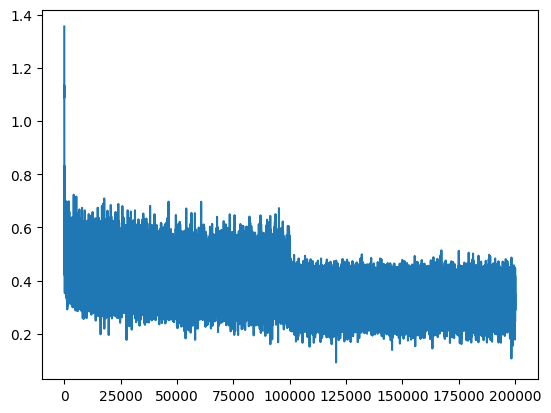

In [48]:
plt.plot(stepi, lossi)

In [49]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1783, grad_fn=<NllLossBackward0>)

In [50]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1955, grad_fn=<NllLossBackward0>)

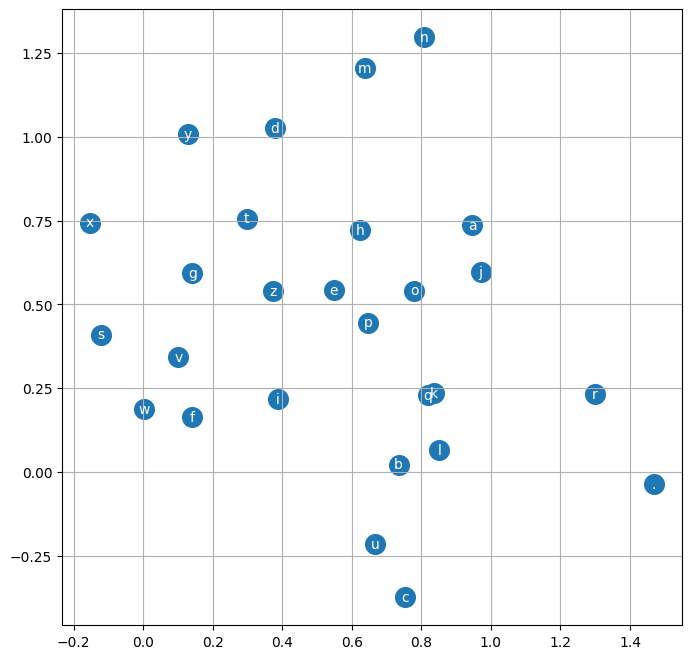

In [51]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [52]:
# training split, dev/validation split, test split
# 80%, 10%, 10%


In [53]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nihayla.
rethan.
emdrlee.
aderedieliighlynnelle.
elieananar.
kayzioh.
kalin.
shuber.
shimiel.
kin.
reth.
koxn.
profy.
brey.
dariyah.
fael.
yuma.
